# PCA e Agrupamento com a Base Credit Card

## Tratamento da base de dados

In [5]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import io

In [7]:
base_credit = pd.read_csv('credit_card_clients.csv', header = 1)
base_credit

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


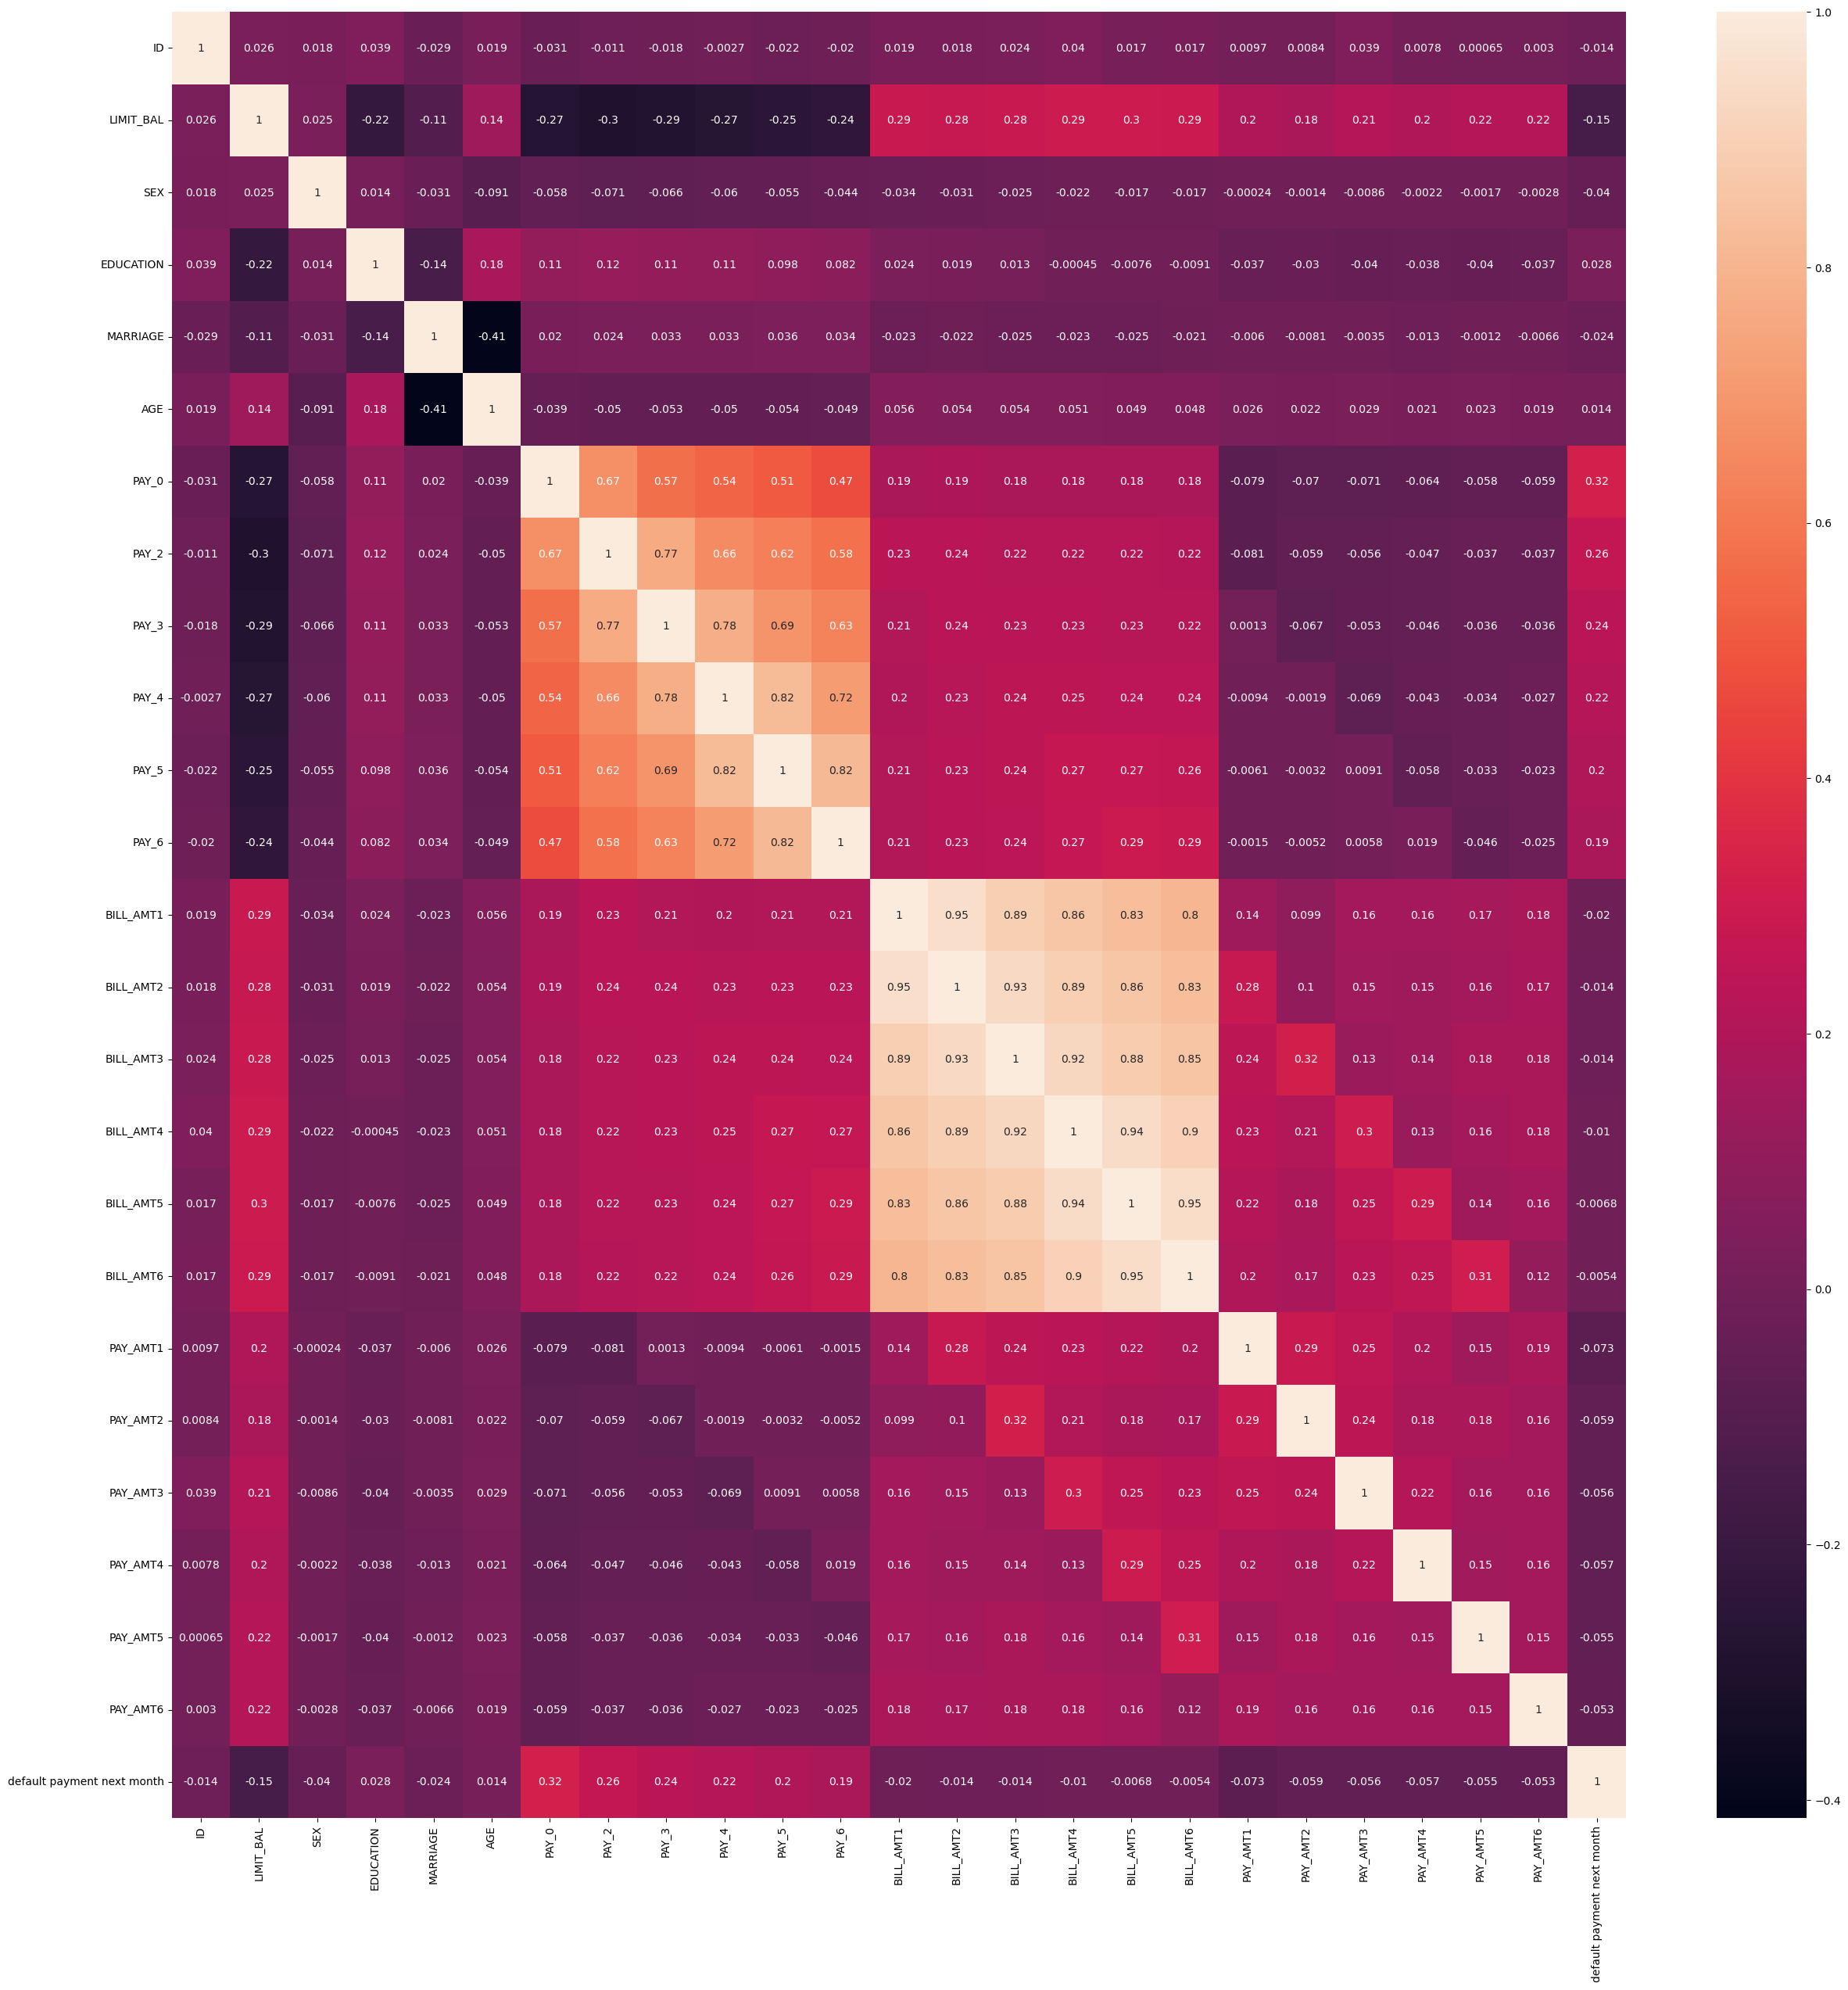

In [8]:
figura = plt.figure(figsize=(30,30))
sns.heatmap(base_credit.corr(), annot=True);

Diminuir o número de colunas seguindo a correlação dos atributos.

In [9]:
base_credit.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [10]:
X = base_credit.iloc[:, 1:len(base_credit.columns)].values
X

array([[ 20000,      2,      2, ...,      0,      0,      1],
       [120000,      2,      2, ...,      0,   2000,      1],
       [ 90000,      2,      2, ...,   1000,   5000,      0],
       ...,
       [ 30000,      1,      2, ...,   2000,   3100,      1],
       [ 80000,      1,      3, ...,  52964,   1804,      1],
       [ 50000,      1,      2, ...,   1000,   1000,      1]])

In [11]:
X.shape

(30000, 24)

In [12]:
# Para enviar os dados ao algoritmo de PCA, será necessário fazer a conversão 
X = np.array(X).astype('float32')
X

array([[2.0000e+04, 2.0000e+00, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.2000e+05, 2.0000e+00, 2.0000e+00, ..., 0.0000e+00, 2.0000e+03,
        1.0000e+00],
       [9.0000e+04, 2.0000e+00, 2.0000e+00, ..., 1.0000e+03, 5.0000e+03,
        0.0000e+00],
       ...,
       [3.0000e+04, 1.0000e+00, 2.0000e+00, ..., 2.0000e+03, 3.1000e+03,
        1.0000e+00],
       [8.0000e+04, 1.0000e+00, 3.0000e+00, ..., 5.2964e+04, 1.8040e+03,
        1.0000e+00],
       [5.0000e+04, 1.0000e+00, 2.0000e+00, ..., 1.0000e+03, 1.0000e+03,
        1.0000e+00]], dtype=float32)

## Configurações SageMaker

In [13]:
import sagemaker
import boto3
from sagemaker import Session

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [14]:
session = sagemaker.Session()
bucket = 'emanuelle-sprint04'
subpasta_modelo = 'modelos/credit-card/pca'
subpasta_dataset = 'datasets/credit-card'
key_train = 'credit-card-train-data-pca'
role = sagemaker.get_execution_role()
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subpasta_dataset, key_train)
output_location = 's3://{}/{}/output'.format(bucket, subpasta_modelo)
print('Role: ', role)
print('Localização da base de dados de treinamento: ', s3_train_data)
print('Modelo final será salvo em: ', output_location)

Role:  arn:aws:iam::831926590523:role/service-role/AmazonSageMaker-ExecutionRole-20250103T092223
Localização da base de dados de treinamento:  s3://emanuelle-sprint04/datasets/credit-card/train/credit-card-train-data-pca
Modelo final será salvo em:  s3://emanuelle-sprint04/modelos/credit-card/pca/output


In [15]:
import sagemaker.amazon.common as smac
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X)
buffer.seek(0)

0

In [16]:
boto3.resource('s3').Bucket(bucket).Object(os.path.join(subpasta_dataset, 'train', key_train)).upload_fileobj(buffer)

## Treinamento do PCA

In [17]:
container = sagemaker.image_uris.retrieve(framework = 'pca', region = boto3.Session().region_name)

In [18]:
pca = sagemaker.estimator.Estimator(image_uri = container,
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.large',
                                    output_path = output_location,
                                    sagemaker_session = session)

In [19]:
pca.set_hyperparameters(feature_dim = 30000,
                        num_components = 2,
                        mini_batch_size = 200)

In [21]:
# caminho da base de dados
s3_train_data

's3://emanuelle-sprint04/datasets/credit-card/train/credit-card-train-data-pca'

In [22]:
pca.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: pca-2025-01-09-11-59-43-199


2025-01-09 11:59:44 Starting - Starting the training job...
2025-01-09 11:59:59 Starting - Preparing the instances for training...
2025-01-09 12:00:32 Downloading - Downloading input data...
2025-01-09 12:00:57 Downloading - Downloading the training image......
2025-01-09 12:02:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[01/09/2025 12:02:20 INFO 140514539358016] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[01/09/2025 12:02:20 

## Redução da Dimensionalidade

In [23]:
# Primeiro é necessário fazer o deploy
pca_predictor = pca.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

INFO:sagemaker:Creating model with name: pca-2025-01-09-12-03-54-115
INFO:sagemaker:Creating endpoint-config with name pca-2025-01-09-12-03-54-115
INFO:sagemaker:Creating endpoint with name pca-2025-01-09-12-03-54-115


---------!

In [24]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
pca_predictor.serializer = CSVSerializer()
pca_predictor.deserializer = JSONDeserializer()

In [25]:
# antes
X[0]

array([ 2.000e+04,  2.000e+00,  2.000e+00,  1.000e+00,  2.400e+01,
        2.000e+00,  2.000e+00, -1.000e+00, -1.000e+00, -2.000e+00,
       -2.000e+00,  3.913e+03,  3.102e+03,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00], dtype=float32)

In [26]:
X0_pca = pca_predictor.predict(X[0])
print(X0_pca)

{'projections': [{'projection': [75538.1875, 166488.125]}]}


Os 24 atributos acima foram reduzidos a dois valores considerados principais. Importante salientar que não conseguimos interpretar o que esses valores representam.

In [27]:
# Fazendo no resto da base
X_pca = pca_predictor.predict(X)

In [28]:
X_pca

{'projections': [{'projection': [75538.1875, 166488.125]},
  {'projection': [-9780.6640625, 114226.9375]},
  {'projection': [33471.40625, 98432.3046875]},
  {'projection': [95224.2734375, 71230.6171875]},
  {'projection': [68729.203125, 114834.546875]},
  {'projection': [97913.7890625, 67063.4375]},
  {'projection': [196044.15625, -1027202.5]},
  {'projection': [7202.8828125, 124842.328125]},
  {'projection': [-17128.3359375, 86857.734375]},
  {'projection': [78307.7890625, 160662.6875]},
  {'projection': [-75357.34375, 68122.7578125]},
  {'projection': [-117693.03125, 18680.296875]},
  {'projection': [-448067.65625, -145861.875]},
  {'projection': [99842.3203125, 22731.984375]},
  {'projection': [-50677.296875, -76998.78125]},
  {'projection': [87440.4375, 84486.7109375]},
  {'projection': [94949.4296875, 131950.609375]},
  {'projection': [10258.8203125, -338039.0625]},
  {'projection': [-221639.75, 2328.375]},
  {'projection': [-65215.640625, 90814.640625]},
  {'projection': [3945.60

In [29]:
X_pca = np.array([r['projection'] for r in X_pca['projections']])

In [30]:
X_pca, X_pca.shape

(array([[ 75538.1875   , 166488.125    ],
        [ -9780.6640625, 114226.9375   ],
        [ 33471.40625  ,  98432.3046875],
        ...,
        [ 77857.5234375, 140206.0625   ],
        [ 74908.3125   ,  41427.6875   ],
        [ 95514.140625 ,  70860.234375 ]]),
 (30000, 2))

In [31]:
X_pca = np.array(X_pca).astype('float32')

## Treinamento do K-Means

In [32]:
subpasta_modelo_kmeans = 'modelos/credit-card/kmeans'
output_location_kmeans = 's3://{}/{}'.format(bucket, subpasta_modelo_kmeans)
print('Modelo kmeans será salvo em: ', output_location_kmeans)

Modelo kmeans será salvo em:  s3://emanuelle-sprint04/modelos/credit-card/kmeans


In [33]:
from sagemaker import KMeans

In [34]:
kmeans = KMeans(role = role,
                instance_count = 1,
                instance_type = 'ml.m5.large',
                output_path = output_location_kmeans,
                k = 4)

In [35]:
kmeans.fit(kmeans.record_set(X_pca))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2025-01-09-12-22-33-440


2025-01-09 12:22:35 Starting - Starting the training job...
2025-01-09 12:22:50 Starting - Preparing the instances for training...
2025-01-09 12:23:21 Downloading - Downloading input data...
2025-01-09 12:24:01 Downloading - Downloading the training image......
2025-01-09 12:25:07 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/09/2025 12:25:09 INFO 140210347902784] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '

## Agrupamento com K-Means

In [36]:
kmeans_predictor = kmeans.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2025-01-09-12-26-58-319
INFO:sagemaker:Creating endpoint-config with name kmeans-2025-01-09-12-26-58-319
INFO:sagemaker:Creating endpoint with name kmeans-2025-01-09-12-26-58-319


-------!

In [37]:
resultados = kmeans_predictor.predict(X_pca)

In [38]:
resultados

[label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 78219.015625
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 73226.25
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 27190.19140625
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 40508.296875
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 0.0
     }
   }
 }
 label {
   key: "distance_t

In [39]:
rotulos = [r.label['closest_cluster'].float32_tensor.values[0] for r in resultados]

In [40]:
print(rotulos[0:10])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]


In [41]:
np.unique(rotulos, return_counts = True)

(array([0., 1., 2., 3.]), array([16289,  4442,  8512,   757]))

In [42]:
base_credit.shape, len(rotulos)

((30000, 25), 30000)

In [43]:
base_credit['cluster'] = rotulos

In [44]:
base_credit 

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,cluster
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,0.0
1,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,0.0
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,0.0
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,0.0
4,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,31237,15980,8500,20000,5003,3047,5000,1000,0,1.0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,5190,0,1837,3526,8998,129,0,0,0,0.0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20582,19357,0,0,22000,4200,2000,3100,1,0.0
29998,29999,80000,1,3,1,41,1,-1,0,0,...,11855,48944,85900,3409,1178,1926,52964,1804,1,0.0


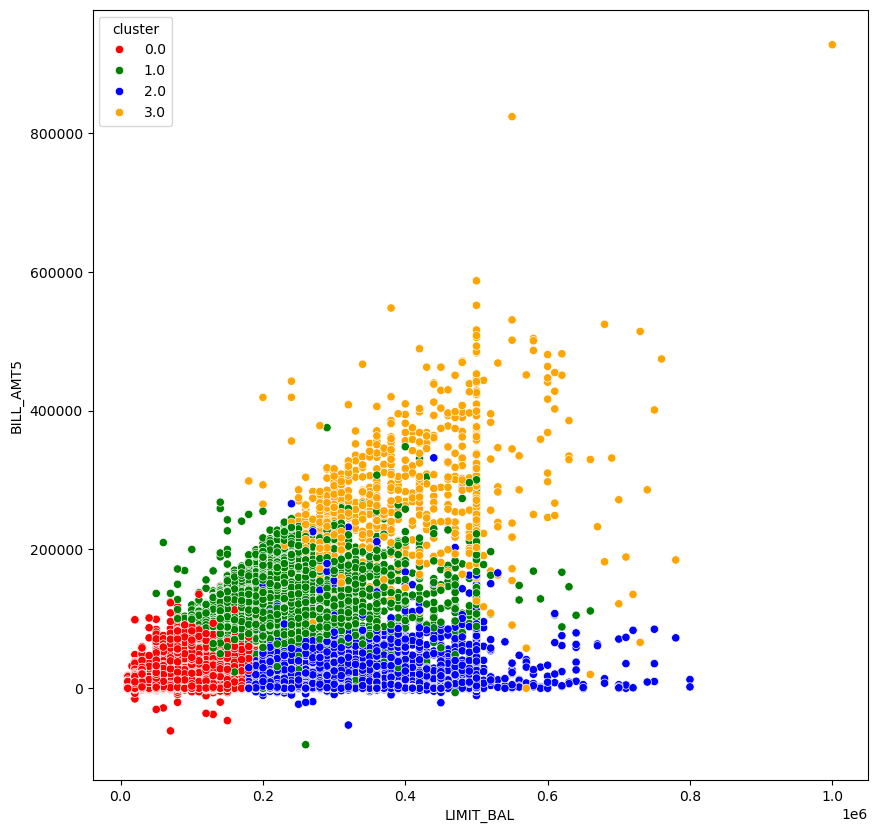

In [45]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'LIMIT_BAL', y = 'BILL_AMT5', data = base_credit, hue = 'cluster', palette = ['red', 'green', 'blue', 'orange']);

In [47]:
base_credit_1 = base_credit[base_credit['cluster'] == 1.0]
base_credit_1

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,cluster
17,18,320000,1,1,1,49,0,0,0,-1,...,5856,195599,10358,10000,75940,20000,195599,50000,0,1.0
36,37,280000,1,2,1,40,0,0,0,0,...,173901,177413,8026,8060,6300,6400,6400,6737,0,1.0
57,58,180000,2,2,1,34,0,0,0,0,...,132202,129918,8083,7296,5253,4814,4816,3800,0,1.0
65,66,200000,1,1,1,57,-2,-2,-2,-1,...,8198,7918,0,0,8222,300,0,1000,1,1.0
80,81,470000,2,3,3,33,0,0,0,0,...,29271,29889,6400,7566,3000,960,1000,3000,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29969,29970,200000,1,2,1,33,0,0,0,0,...,58826,67577,5000,2183,2059,3000,9751,3000,0,1.0
29977,29978,420000,1,1,2,34,0,0,0,0,...,144839,147954,7000,7000,5500,5500,5600,5000,0,1.0
29988,29989,250000,1,1,1,34,0,0,0,0,...,175005,179687,65000,8800,9011,6000,7000,6009,0,1.0
29990,29991,140000,1,2,1,41,0,0,0,0,...,49675,46121,6000,7000,4228,1505,2000,2000,0,1.0


In [48]:
base_credit_1.to_csv('base_credit_1.csv')

In [52]:
import boto3

sagemaker_client = boto3.client('sagemaker')
endpoint_name = 'pca-2025-01-09-12-03-54-115'

# Exclui o endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

# Exclui a configuração do endpoint e modelo (opcional, mas recomendado)
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
sagemaker_client.delete_model(ModelName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bdfd6576-a94f-4130-a26d-ea9b086ee165',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bdfd6576-a94f-4130-a26d-ea9b086ee165',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 09 Jan 2025 12:41:30 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [53]:
import boto3

sagemaker_client = boto3.client('sagemaker')
endpoint_name = 'kmeans-2025-01-09-12-26-58-319'

# Exclui o endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

# Exclui a configuração do endpoint e modelo (opcional, mas recomendado)
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
sagemaker_client.delete_model(ModelName=endpoint_name)

{'ResponseMetadata': {'RequestId': '3ae7a9ce-f684-42ff-a145-97416a6e005b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3ae7a9ce-f684-42ff-a145-97416a6e005b',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 09 Jan 2025 12:41:48 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [ ]:
# Não consegui fazer a parte do mxnet pois deu erro no numpy (provavelmente biblioteca desatualizada).